# 1 Load packages and functions

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
try:
  import mat73
except:
  !pip install mat73
  import mat73

In [3]:
!pip install -q tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.65 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import collections
import os
import matplotlib.pyplot as plt
import datetime, time
import scipy
import seaborn as sns

from numpy import linalg as LA

import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas.core.algorithms as algos
from pandas import Series
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, dot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Reshape, BatchNormalization, TimeDistributed, \
                         Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.backend import abs

from tensorflow.keras.layers import Dense, Dropout, Flatten, dot, Permute, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D

from tensorflow.keras.layers import add

In [6]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon,np.abs(y_true)))) * 100

In [8]:
def smape(A, F):
    return ((100.0/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))+ np.finfo(float).eps))

In [9]:
# Relative root mean square error
def RRMSE (real, predicted):
  a = np.linalg.norm((real-predicted), ord='fro')
  b = np.linalg.norm(real, ord='fro')
  return(a/b)

# 2 Load dataset

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
os.chdir("//content/drive/My Drive/abadiaheredia_etal_2024/")

In [12]:
"""
    Laminar flow
"""

data_dict = mat73.loadmat('DATA/dataset_laminar.mat')
Ten_orig = data_dict['Tensor'][:2,:,:,:,100:]

"""
    Turbulent flow
"""

# data_dict = mat73.loadmat('DATA/dataset_turbulent.mat')
# Ten_orig = data_dict['Tensor'][0:1, ...]

'\n    Turbulent flow\n'

In [13]:
Ten_orig.shape

(2, 100, 40, 64, 499)

### Original Tensor reconstruction

In [14]:
# Reshape the matrix in order to recover the original tensor
Mat_orig = np.reshape(np.copy(Ten_orig), [np.product(Ten_orig.shape[:-1]), Ten_orig.shape[-1]], order = 'F')
Mat_orig.shape

(512000, 499)

In [17]:
"""
    Laminar flow
"""

train_set = np.copy(Ten_orig[...,:int(0.6 * Ten_orig.shape[-1])])
dev_set   = np.copy(Ten_orig[...,:int(0.65 * Ten_orig.shape[-1])])

"""
    Turbulent flow
"""

# train_set = np.copy(Ten_orig[...,:int(0.7 * Ten_orig.shape[-1])])
# dev_set   = np.copy(Ten_orig[...,:int(0.75 * Ten_orig.shape[-1])])

train_mean  = np.mean(train_set, axis = -1)[..., None]
dev_mean    = np.mean(dev_set, axis = -1)[..., None]

train_set -= train_mean
dev_set   -= dev_mean

print(train_set.shape)
print(dev_set.shape)

(2, 100, 40, 64, 299)
(2, 100, 40, 64, 324)


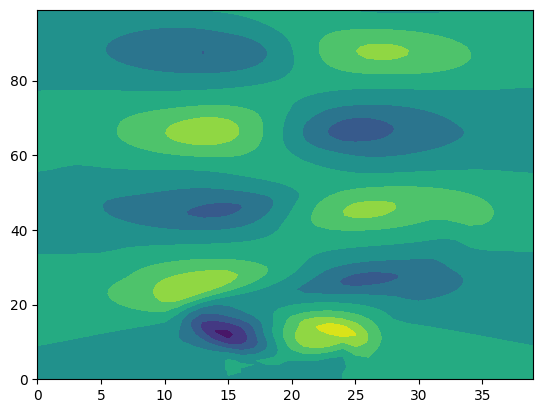

In [18]:
plt.close('all')
plt.contourf(train_set[0,:,:,32,10])
# plt.contourf(train_set[0,:,:,10])

In [19]:
Utr, Str, VTtr = LA.svd(
    np.reshape(
        np.copy(train_set),
        [np.product(train_set.shape[:-1]), train_set.shape[-1]],
        order = 'F'),
    full_matrices = False)

Udev, Sdev, VTdev = LA.svd(
    np.reshape(
        np.copy(dev_set),
        [np.product(dev_set.shape[:-1]), dev_set.shape[-1]],
        order = 'F'),
    full_matrices = False)

In [20]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [21]:
from matplotlib import rc
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Sans",
    "font.size": 24
})
rc('text', usetex=True)

Text(0, 0.5, 'E$[n]$')

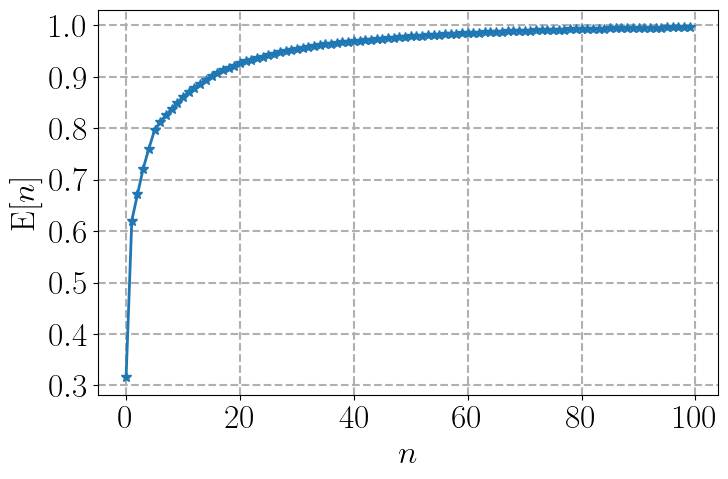

In [23]:
fig = plt.figure(figsize = (8, 5))

_ = np.cumsum(Str)
plt.plot(_[:100] / _[-1], '-*', linewidth = 2, markersize = 7)
plt.yticks(np.arange(0.3, 1.01, 0.1))
# plt.yticks(np.arange(0.0, 0.55, 0.05))

# _ = Str**2 / (VTtr.shape[-1] - 1)
# plt.semilogy(_[:100] / _[0], '-*', linewidth = 2, markersize = 7)
# plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])

# plt.semilogy(Str[:100] / Str[0], '-*', linewidth = 2, markersize = 7)
# plt.yticks([1e-3, 1e-2, 1e-1, 1.0])
# plt.yticks([0.05, 0.07, 0.1, 0.2, 0.5, 0.7, 1])

plt.grid(True, linewidth = 1.5, linestyle = '--')
plt.xlabel("$n$")
plt.ylabel("E$[n]$")

In [ ]:
rrmse = np.norm()

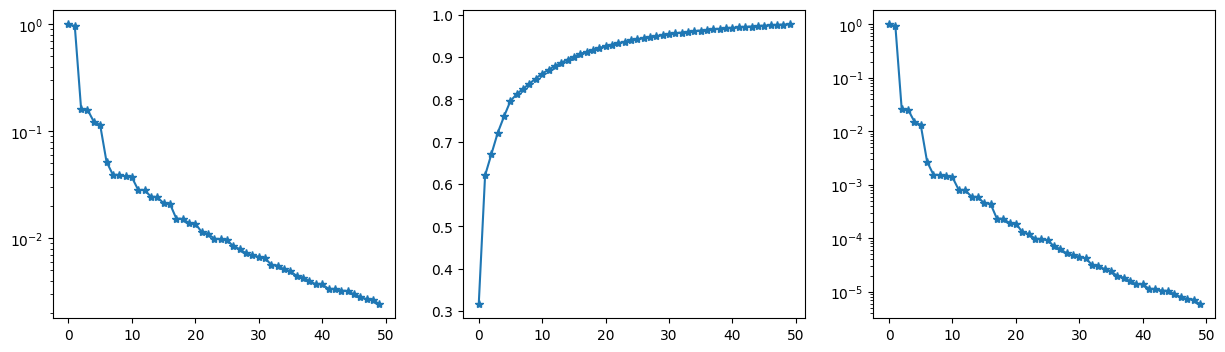

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
axs[0].plot(Str[:50] / np.max(Str), '-*')
axs[0].set_yscale('log')

_ = np.cumsum(Str)
axs[1].plot(_[:50] / _[-1], '-*')

_ = Str**2 / (VTtr.shape[-1] - 1)
axs[2].plot(_[:50] / _[0], '-*')
axs[2].set_yscale('log')

In [ ]:
num_modes = 20 # 20

_ = np.cumsum(Str/np.max(Str))
print(f"Energy contained: {_[num_modes]/_[-1]}")
_ = Str/np.max(Str)
print(_[num_modes + 1]/_[0])
_ = Str**2 / (VTtr.shape[-1] - 1)
print(_[num_modes] / _[0])

del _

Energy contained: 0.9260419812610753
0.01142122734886966
0.00018826487775754322


In [ ]:
AML_train = np.diag(Str[:num_modes]) @ VTtr[:num_modes,:]
AML_dev = np.diag(Sdev[:num_modes]) @ VTdev[:num_modes,:]

### SVD

In [ ]:
train_set_recon = np.dot(np.copy(Utr[:,:num_modes]), np.copy(AML_train))
train_set_recon = np.reshape(train_set_recon, train_set.shape, order = 'F')
# train_set_recon = train_set_recon + train_mean

dev_set_recon = np.dot(np.copy(Udev[:,:num_modes]), np.copy(AML_dev))
dev_set_recon = np.reshape(dev_set_recon, [*dev_set.shape[:-1], AML_dev.shape[-1]], order = 'F')
# dev_set_recon = dev_set_recon + dev_mean

'\n    Turbulent dataset\n'

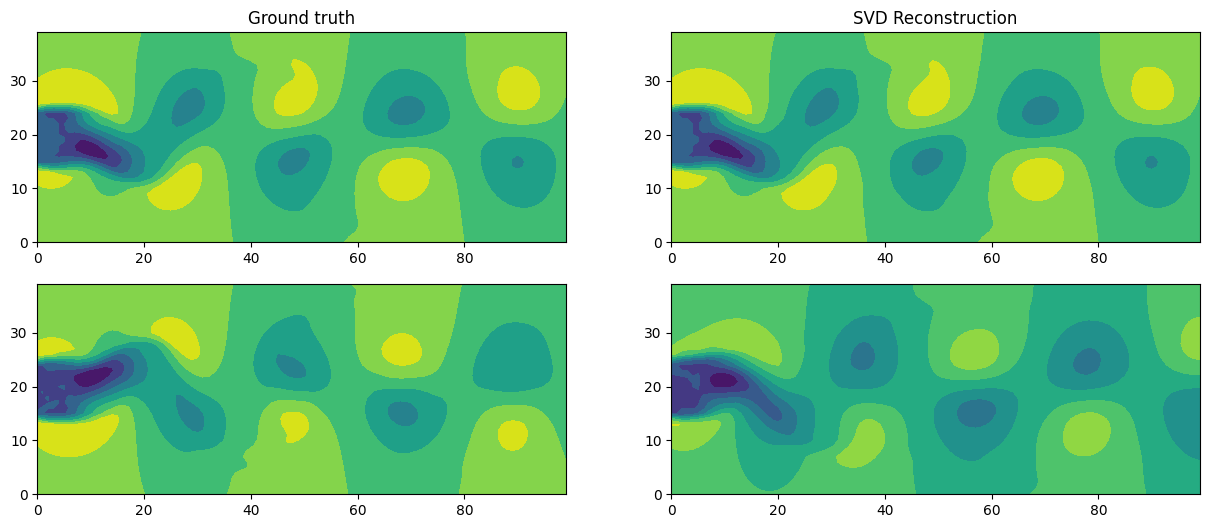

In [ ]:
"""
    Laminar dataset
"""

fig, axs = plt.subplots(2, 2, figsize = (15,6))
axs[0,0].contourf(Ten_orig[0,:,:,15,100].T)
axs[0,0].set_title("Ground truth")
axs[0,1].contourf(train_set_recon[0,:,:,15,100].T + train_mean[0, :, :, 15, 0].T)
axs[0,1].set_title("SVD Reconstruction")

axs[1,0].contourf(Ten_orig[0,:,:,15,train_set_recon.shape[-1] + 16].T)
axs[1,1].contourf(dev_set_recon[0,:,:,15,16].T + dev_mean[0, :, :, 15, 0].T)

"""
    Turbulent dataset
"""

# fig, axs = plt.subplots(2, 2, figsize = (15,6))
# axs[0,0].contourf(Ten_orig[0,:,:,100])
# axs[0,0].set_title("Ground truth")
# axs[0,1].contourf(train_set_recon[0,:,:,100] + train_mean[0,:,:,0])
# axs[0,1].set_title("SVD Reconstruction")

# axs[1,0].contourf(Ten_orig[0,:,:,train_set_recon.shape[-1] + 115])
# axs[1,1].contourf(dev_set_recon[0,:,:,115] + dev_mean[0,:,:,0])

### AML Matrix construction

In [ ]:
tensor = np.concatenate([np.copy(AML_train), np.copy(AML_dev)], axis = 1)
tensor_test = np.copy(AML_dev)

### Dataset characteristics

In [ ]:
# min, max, range and standard deviation of values
min_val = np.amin(tensor)
max_val = np.amax(tensor)
range_val = np.ptp(tensor)
std_val =np.std(tensor)

### Data scaling

In [ ]:
tensor_norm = (tensor-min_val)/range_val
tensor_test_norm = (tensor_test-min_val)/range_val
scipy.stats.describe(tensor_norm.flatten())

DescribeResult(nobs=12460, minmax=(0.0, 1.0), mean=0.5016552921239207, variance=0.01235358526516242, skewness=-0.015863127155722457, kurtosis=10.699768817176057)

### Dataset configuration

In [ ]:
total_length = tensor_norm.shape[1]
channels_n = 0
dim_x = tensor_norm.shape[0]
dim_y = 0

print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)

total_length:  623
channels_n:  0
dim_x:  20
dim_y:  0


# 3 Prepare training and test sets

In [ ]:
# We will use a data generator
import math
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, list_IDs, batch_size=5, dim=(20),
                 k = 624, p = 1,
                 shuffle=True, till_end = False, only_test = False):
        'Initialization'
        self.data = data
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.p = p
        self.k = k
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.till_end:
          lenx = math.ceil((len(self.list_IDs) / self.batch_size))
        else:
          lenx = int(np.floor(len(self.list_IDs) / self.batch_size))
        return lenx

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        if self.only_test:
          return X
        else:
          return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, depth)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.k))
        y = [np.empty((self.batch_size, self.dim))]*self.p

        y_inter = np.empty((self.batch_size, self.dim, p))

        # Generate data
        lenn = len(list_IDs_temp)
        for i, ID in enumerate(list_IDs_temp):
            # Store Xtrain
            X[i,:,:] = self.data[:,ID:ID+k]
            # Store Ytrain
            y_inter[i,:,:] = self.data[:,ID+k:ID+k+p]

        for j in range(self.p):
          y[j] = y_inter[:,:,j]
          y[j] = np.reshape(y[j], (lenn, -1))

        X = X.transpose((0,2,1))

        return X, y



In [ ]:
# Configure the data generators

# Prepare the dataset indexes
period_transitorio = 0
stride_train = 1
stride_val = 1
stride_test = 1

batch_size = 5
dim=(dim_x)
print("dim: ",dim)
k = 10  # number of snapshots used as predictors
p = 6   # number of snapshots used as time-ahead predictions

test_length = AML_dev.shape[-1]
val_length  = AML_dev.shape[1]
train_length = AML_train.shape[1]

if int(train_length-period_transitorio-(k+p)) < 0:
    train_n = 0
elif int((train_length-period_transitorio-(k+p))//stride_train) == 0:
    train_n = 1
else:
    train_n = int(((train_length-period_transitorio)-(k+p))//stride_train) + 1 # falta sumar 1???

if int(test_length-period_transitorio-(k+p)) < 0:
    test_n = 0
elif int((test_length-period_transitorio-(k+p))//stride_test) == 0:
    test_n = 1
else:
    test_n = int((test_length-period_transitorio-(k+p))//stride_test) + 1 # falta sumar 1???

if int(val_length-(k+p)) < 0:
    val_n = 0
elif int((val_length-(k+p))//stride_val) == 0:
    val_n = 1
else:
    val_n = int((val_length-(k+p))//stride_val) + 1 # falta sumar 1???

# Indices for the beginnings of each batch
train_idxs = np.empty([train_n], dtype='int')
val_idxs = np.empty([val_n], dtype='int')
test_idxs = np.empty([test_n], dtype='int')

j = period_transitorio
for i in range(train_n):
    train_idxs[i] = j
    j = j+stride_train

j = train_length
for i in range(val_n):
    val_idxs[i] = j
    j = j+stride_val

j = train_length
for i in range(test_n):
    test_idxs[i] = j
    j = j+stride_test



# Generators
training_generator = DataGenerator(tensor_norm, train_idxs,
                                    dim = dim,
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = False,
                                    shuffle = True)
validation_generator = DataGenerator(tensor_norm, val_idxs,
                                    dim = dim,
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = False,
                                    shuffle = False)
test_generator = DataGenerator(tensor_test_norm, test_idxs,
                                    dim = dim,
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = True,
                                    shuffle = False)

print ('test_length: ', test_length)
print ('val_length: ', val_length)
print ('train_length: ', train_length)
print()
print ('test_n: ', test_n)
print ('val_n: ', val_n)
print ('train_n: ', train_n)
print()
print('test_generator_len: ', len(test_generator))
print('validation_generator_len: ', len(validation_generator))
print('training_generator_len: ', len(training_generator))

dim:  20
test_length:  324
val_length:  324
train_length:  299

test_n:  309
val_n:  309
train_n:  284

test_generator_len:  61
validation_generator_len:  61
training_generator_len:  56


# 4 Model LSTM 100 nodes

## 4.1 Prepare model

In [ ]:
tf.keras.backend.clear_session

def create_model(in_shape,  out_dim, p = 3, shared_dim = 1000, act_fun= 'relu'):
    x = Input(shape=in_shape)

    v = LSTM(100)(x)
    v = Dense(p*100, activation= act_fun)(v)
    v = Reshape((p,100))(v)

    tt = [1]*p

    r = TimeDistributed( Dense(shared_dim, activation=act_fun))(v)
    s = tf.split(r, tt, 1)
    for i in range(p):
      s[i] = Flatten()(s[i])

    o = []
    for i in range(p):
      o.append( Dense(out_dim, activation='sigmoid')(s[i]) )

    m = Model(inputs=x, outputs=o)
    m.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return(m)

In [ ]:
#create the model

in_shape = [k, dim_x]
out_dim = dim_x
shared_dim = 80
print(in_shape)
print(out_dim)
print(shared_dim)


model= create_model(in_shape,out_dim,p,shared_dim)

[10, 20]
20
80


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 20)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 100)                  48400     ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 600)                  60600     ['lstm[0][0]']                
                                                                                                  
 reshape (Reshape)           (None, 6, 100)               0         ['dense[0][0]']               
                                                                                              

In [ ]:
# save the best weights
import sys
# save_string = 'colab_Cilin3D_AML_20_LSTM_100 v1'

save_string = 'svdLSTM_NOMEAN_FINAL'

# save the best weights
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'


## 4.2 Training

In [ ]:
np.random.seed(247531338)
tf.random.set_seed(31722973)

In [ ]:
t0 = time.time()

num_epochs = 140 * 3

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs = num_epochs,
    verbose = 1
)

t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Epoch 1/420
56/56 [==============================] - 5s 21ms/step - loss: 0.0742 - dense_2_loss: 0.0124 - dense_3_loss: 0.0124 - dense_4_loss: 0.0124 - dense_5_loss: 0.0124 - dense_6_loss: 0.0124 - dense_7_loss: 0.0123 - dense_2_mse: 0.0124 - dense_3_mse: 0.0124 - dense_4_mse: 0.0124 - dense_5_mse: 0.0124 - dense_6_mse: 0.0124 - dense_7_mse: 0.0123 - val_loss: 0.0725 - val_dense_2_loss: 0.0121 - val_dense_3_loss: 0.0121 - val_dense_4_loss: 0.0121 - val_dense_5_loss: 0.0120 - val_dense_6_loss: 0.0121 - val_dense_7_loss: 0.0120 - val_dense_2_mse: 0.0121 - val_dense_3_mse: 0.0121 - val_dense_4_mse: 0.0121 - val_dense_5_mse: 0.0120 - val_dense_6_mse: 0.0121 - val_dense_7_mse: 0.0120
Epoch 2/420
56/56 [==============================] - 1s 10ms/step - loss: 0.0528 - dense_2_loss: 0.0087 - dense_3_loss: 0.0088 - dense_4_loss: 0.0092 - dense_5_loss: 0.0087 - dense_6_loss: 0.0091 - dense_7_loss: 0.0083 - dense_2_mse: 0.0087 - dense_3_mse: 0.0088 - dense_4_mse: 0.0092 - dense_5_mse: 0.0087 - den

In [ ]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({
    'epoch': [ i + 1 for i in history.epoch ],
    'train_loss': history.history['loss'],
    'valid_loss': history.history['val_loss']
})

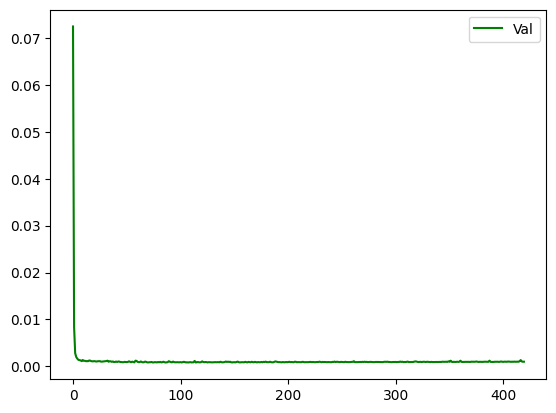

Minimum val_loss at epoch 87 = 0.0008


In [ ]:
plt.plot(summary_stats.valid_loss, 'g', label = 'Val') # green
# plt.ylim((0,0.002))
plt.legend()
plt.show()

# Find the min validation loss during the training
min_loss, idx = min((loss, idx) for (idx, loss) in enumerate(history.history['val_loss']))
print('Minimum val_loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_loss))
min_loss = round(min_loss, 4)


In [ ]:
def evaluate_model_test_iter(ten_orig_1, time_pred = 10, inputWidth = 10):

  ten_orig = np.copy(ten_orig_1)

  predictions = np.empty((ten_orig.shape[0], time_pred * 6))

  snap = np.copy(ten_orig[..., -inputWidth:])

  snap = np.transpose(snap, [1,0])
  snap = snap[None, ...]

  for i in range(time_pred):

    pred = model.predict(snap, verbose = 0)
    pred = np.copy(np.array(pred))
    pred = np.transpose(pred, [1,0,2])

    pred_1 = np.copy(pred[0,:,:]) * range_val + min_val

    predictions[..., i*6 : (i+1)*6] = pred_1.T

    snap = np.concatenate([snap[:,6:,:], pred], axis = 1)

  del ten_orig, snap, pred, pred_1

  return predictions


In [ ]:
t0 = time.time()

predictions = evaluate_model_test_iter(tensor_norm[:,:AML_train.shape[-1]], time_pred = 34, inputWidth = 10)

t1 = time.time()

print(t1 - t0)

2.415404796600342


'\n    Turbulent dataset\n'

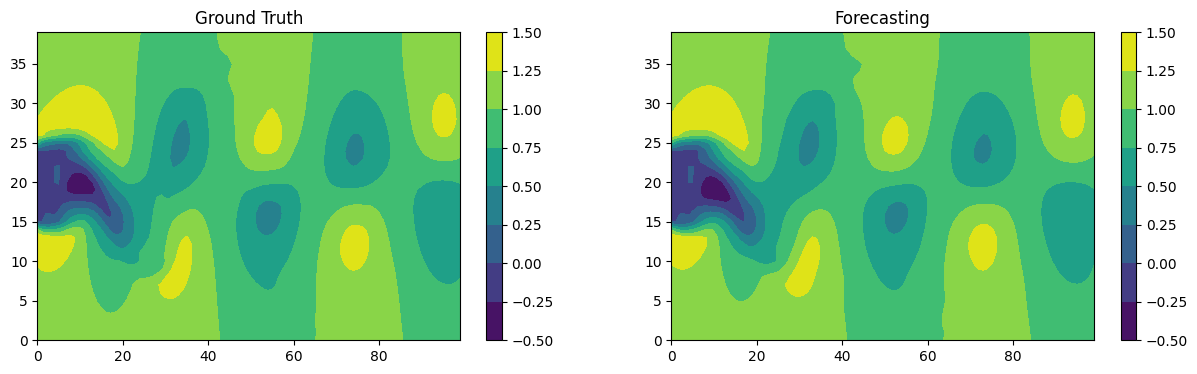

In [ ]:
_ = Utr[:,:num_modes] @ predictions
_ = np.reshape(_, [*Ten_orig.shape[:-1], predictions.shape[-1]], order = 'F')

select_snap = 199
comp = 0

"""
    Laminar dataset
"""

vmin = np.amin(Ten_orig[0,:,:,32, AML_train.shape[-1] + select_snap])
vmax = np.amax(Ten_orig[0,:,:,32, AML_train.shape[-1] + select_snap])

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize = (15,4))
im = axs[0].contourf(Ten_orig[comp,:,:,32, AML_train.shape[-1] + select_snap].T, vmin = vmin, vmax = vmax)
plt.colorbar(im, ax = axs[0])
axs[0].set_title('Ground Truth')

im = axs[1].contourf(_[comp,:,:,32,select_snap].T + train_mean[comp,:,:,32,0].T, vmin = vmin, vmax = vmax)
plt.colorbar(im, ax = axs[1])
axs[1].set_title('Forecasting')

"""
    Turbulent dataset
"""

# vmin = np.amin(Ten_orig[0,:,:, AML_train.shape[-1] + select_snap])
# vmax = np.amax(Ten_orig[0,:,:, AML_train.shape[-1] + select_snap])

# plt.close('all')
# fig, axs = plt.subplots(1, 2, figsize = (15,4))
# im = axs[0].contourf(Ten_orig[comp,:,:, AML_train.shape[-1] + select_snap], vmin = vmin, vmax = vmax)
# plt.colorbar(im, ax = axs[0])
# axs[0].set_title('Ground Truth')

# im = axs[1].contourf(_[comp,:,:,select_snap] + train_mean[comp,:,:,0], vmin = vmin, vmax = vmax)
# plt.colorbar(im, ax = axs[1])
# axs[1].set_title('Forecasting')

In [ ]:
np.save('predictions_POD_DL.npy', _ + train_mean)